In [22]:
import pygame

# 需要获取操作系统类型，故而调用sys包
import sys
def load():
    # 加载各类资源的函数
    # 精灵在不同状态下的图片
    PLAYER_PATH = (
            'assets/sprites/redbird-upflap.png',
            'assets/sprites/redbird-midflap.png',
            'assets/sprites/redbird-downflap.png'
    )

    # 背景图地址
    BACKGROUND_PATH = 'assets/sprites/background-black.png'

    # 管道图片所在的地址
    PIPE_PATH = 'assets/sprites/pipe-green.png'

    IMAGES, SOUNDS, HITMASKS = {}, {}, {}

    # 加载成绩数字所需的图片
    IMAGES['numbers'] = (
        pygame.image.load('assets/sprites/0.png').convert_alpha(),
        pygame.image.load('assets/sprites/1.png').convert_alpha(),
        pygame.image.load('assets/sprites/2.png').convert_alpha(),
        pygame.image.load('assets/sprites/3.png').convert_alpha(),
        pygame.image.load('assets/sprites/4.png').convert_alpha(),
        pygame.image.load('assets/sprites/5.png').convert_alpha(),
        pygame.image.load('assets/sprites/6.png').convert_alpha(),
        pygame.image.load('assets/sprites/7.png').convert_alpha(),
        pygame.image.load('assets/sprites/8.png').convert_alpha(),
        pygame.image.load('assets/sprites/9.png').convert_alpha()
    )

    # 加载地面的图片
    IMAGES['base'] = pygame.image.load('assets/sprites/base.png').convert_alpha()

    # 加载声音文件（在不同的系统中，声音文件扩展名不同）
    if 'win' in sys.platform:
        soundExt = '.wav'
    else:
        soundExt = '.ogg'

    SOUNDS['die']    = pygame.mixer.Sound('assets/audio/die' + soundExt)
    SOUNDS['hit']    = pygame.mixer.Sound('assets/audio/hit' + soundExt)
    SOUNDS['point']  = pygame.mixer.Sound('assets/audio/point' + soundExt)
    SOUNDS['swoosh'] = pygame.mixer.Sound('assets/audio/swoosh' + soundExt)
    SOUNDS['wing']   = pygame.mixer.Sound('assets/audio/wing' + soundExt)

    # 加载背景图
    IMAGES['background'] = pygame.image.load(BACKGROUND_PATH).convert()

    # s加载精灵图
    IMAGES['player'] = (
        pygame.image.load(PLAYER_PATH[0]).convert_alpha(),
        pygame.image.load(PLAYER_PATH[1]).convert_alpha(),
        pygame.image.load(PLAYER_PATH[2]).convert_alpha(),
    )

    # 加载水管
    IMAGES['pipe'] = (
        pygame.transform.rotate(
            pygame.image.load(PIPE_PATH).convert_alpha(), 180),
            pygame.image.load(PIPE_PATH).convert_alpha(),
    )

    # 获得水管的蒙板
    HITMASKS['pipe'] = (
        getHitmask(IMAGES['pipe'][0]),
        getHitmask(IMAGES['pipe'][1]),
    )

    # 玩家的蒙板
    HITMASKS['player'] = (
        getHitmask(IMAGES['player'][0]),
        getHitmask(IMAGES['player'][1]),
        getHitmask(IMAGES['player'][2]),
    )

    #返回了三个字典，每个字典的值分别存储图像、声音和蒙板
    return IMAGES, SOUNDS, HITMASKS

def getHitmask(image):
    """根据图像的alpha，获得蒙板"""
    #所谓蒙板就是指将图像中的主体从整个图像中抠出来的技术，从而方便与其它的对象合成到一起
    #蒙板用一个boolean类型的列表来存储
    mask = []
    for x in range(image.get_width()):
        mask.append([])
        for y in range(image.get_height()):
            mask[x].append(bool(image.get_at((x,y))[3])) #获取alpha，alpha为图形的透明度         
    return mask
    

In [38]:
# 加载程序所需的包
import numpy as np
import sys
import random
import pygame
import pygame.surfarray as surfarray
from pygame.locals import *
from itertools import cycle
%matplotlib inline

FPS = 30 #帧率
SCREENWIDTH  = 288 #屏幕的宽度
SCREENHEIGHT = 512 #屏幕的高度

pygame.init() #游戏初始化
FPSCLOCK = pygame.time.Clock() #定义程序时钟
SCREEN = pygame.display.set_mode((SCREENWIDTH, SCREENHEIGHT)) #定义屏幕对象
pygame.display.set_caption('Flappy Bird') #设定窗口名称

IMAGES, SOUNDS, HITMASKS = load() #加载游戏资源
PIPEGAPSIZE = 100 # 定义两个水管之间的宽度
BASEY = SCREENHEIGHT * 0.79 #设定基地的高度

# 设定小鸟属性：宽度、高度等
PLAYER_WIDTH = IMAGES['player'][0].get_width()
PLAYER_HEIGHT = IMAGES['player'][0].get_height()
print(IMAGES['player'][0].get_width())
print( IMAGES['player'][0].get_height())
print('player_height:',PLAYER_HEIGHT)
print('player_width:',PLAYER_WIDTH)
POSITION = []
# 设定水管属性：高度、宽度
PIPE_WIDTH = IMAGES['pipe'][0].get_width()
PIPE_HEIGHT = IMAGES['pipe'][0].get_height()
print('pipe_width:',PIPE_WIDTH)
#背景宽度
BACKGROUND_WIDTH = IMAGES['background'].get_width()

PLAYER_INDEX_GEN = cycle([0, 1, 2, 1])
print("self.playery",int((SCREENHEIGHT - PLAYER_HEIGHT) / 2))
print("self.playerx",int(SCREENWIDTH * 0.2))


# 游戏模型类
class GameState:
    def __init__(self):
        # 初始化
        # 初始成绩、玩家索引、循环迭代都为0
        self.score = self.playerIndex = self.loopIter = self.final_score = 0
        
        #设定玩家的初始位置
        self.playerx = int(SCREENWIDTH * 0.2)
        self.playery = int((SCREENHEIGHT - PLAYER_HEIGHT) / 2)
       
        self.basex = 0
        # 地面的初始移位
        self.baseShift = IMAGES['base'].get_width() - BACKGROUND_WIDTH
 
        # 生成两个随机的水管
        newPipe1 = getRandomPipe()
        newPipe2 = getRandomPipe()
        
        # 设定初始水管的位置x，y坐标
        self.upperPipes = [
            {'x': SCREENWIDTH, 'y': newPipe1[0]['y']},
            {'x': SCREENWIDTH + (SCREENWIDTH / 2), 'y': newPipe2[0]['y']},
        ]
        self.lowerPipes = [
            {'x': SCREENWIDTH, 'y': newPipe1[1]['y']},
            {'x': SCREENWIDTH + (SCREENWIDTH / 2), 'y': newPipe2[1]['y']},
        ]

        # 定义玩家的属性
        self.pipeVelX = -4
        self.playerVelY    =  0    # 小鸟在y轴上的速度，初始设置维playerFlapped
        self.playerMaxVelY =  10   # Y轴上的最大速度, 也就是最大的下降速度
        self.playerMinVelY =  -8   # Y轴向上的最大速度
        self.playerAccY    =   1   # 小鸟往下落的加速度
        self.playerFlapAcc =  -9   # 扇动翅膀的加速度
        self.playerFlapped = False # 玩家是否煽动了翅膀

    def frame_step(self, input_actions):
        # input_actions是一个行动数组，分别存储了0或者1两个动作的激活情况
        # 游戏每一帧的循环
        pygame.event.pump()

        # 每一步的默认回报
        reward = 0.1
        terminal = False

        # 限定每一帧只能做一个动作
        if sum(input_actions) != 1:
            raise ValueError('Multiple input actions!')

        # input_actions[0] == 1: 对应什么都不做
        # input_actions[1] == 1: 对应小鸟煽动了翅膀
        if input_actions[1] == 1:
            # 小鸟煽动翅膀向上
            if self.playery > -2 * PLAYER_HEIGHT:
                self.playerVelY = self.playerFlapAcc
                self.playerFlapped = True
                SOUNDS['wing'].play()
        
        # 检查是否通过了管道，如果通过，则增加成绩
        playerMidPos = self.playerx + PLAYER_WIDTH / 2
        for pipe in self.upperPipes:
            pipeMidPos = pipe['x'] + PIPE_WIDTH / 2
            if pipeMidPos <= playerMidPos < pipeMidPos + 4:
                self.score += 1
                self.final_score += 1
                SOUNDS['point'].play()
                reward = 1

        # playerIndex轮换
        if (self.loopIter + 1) % 3 == 0:
            self.playerIndex = next(PLAYER_INDEX_GEN)
        self.loopIter = (self.loopIter + 1) % 30
        self.basex = -((-self.basex + 100) % self.baseShift)

        # 小鸟运动
        if self.playerVelY < self.playerMaxVelY and not self.playerFlapped:
            self.playerVelY += self.playerAccY
        if self.playerFlapped:
            self.playerFlapped = False
        self.playery += min(self.playerVelY, BASEY - self.playery - PLAYER_HEIGHT)
        if self.playery < 0:
            self.playery = 0

        # 管道的移动
        for uPipe, lPipe in zip(self.upperPipes, self.lowerPipes):
            uPipe['x'] += self.pipeVelX
            lPipe['x'] += self.pipeVelX

        # 当管道快到左侧边缘的时候，产生新的管道
        if 0 < self.upperPipes[0]['x'] < 5:
            newPipe = getRandomPipe()
            self.upperPipes.append(newPipe[0])
            self.lowerPipes.append(newPipe[1])

        # 当第一个管道移出屏幕的时候，就把它删除
        if self.upperPipes[0]['x'] < -PIPE_WIDTH:
            self.upperPipes.pop(0)
            self.lowerPipes.pop(0)

        # 检查碰撞
        isCrash= checkCrash({'x': self.playerx, 'y': self.playery,
                             'index': self.playerIndex},
                            self.upperPipes, self.lowerPipes)
        # 如果有碰撞发生，则游戏结束，terminal＝True
        if isCrash:
            SOUNDS['hit'].play()
            #SOUNDS['die'].play()
            terminal = True
            print(self.final_score)
            f = open('score.txt','a')
            f.write('\n'+str( self.final_score))
            self.__init__()
            reward = -1
            
            
            
        # 将所有角色都根据每个角色的坐标画到屏幕上
        SCREEN.blit(IMAGES['background'], (0,0))

        for uPipe, lPipe in zip(self.upperPipes, self.lowerPipes):
            SCREEN.blit(IMAGES['pipe'][0], (uPipe['x'], uPipe['y']))
            SCREEN.blit(IMAGES['pipe'][1], (lPipe['x'], lPipe['y']))

        SCREEN.blit(IMAGES['base'], (self.basex, BASEY))
        
        # print score so player overlaps the score
        showScore(self.score)
        SCREEN.blit(IMAGES['player'][self.playerIndex],
                    (self.playerx, self.playery))

        # 将当前的游戏屏幕生成一个二维画面返回
        image_data = pygame.surfarray.array3d(pygame.display.get_surface())
        pygame.display.update()
        FPSCLOCK.tick(FPS)
        #print self.upperPipes[0]['y'] + PIPE_HEIGHT - int(BASEY * 0.2)
        # 该函数的输出有三个变量：游戏当前帧的游戏画面，当前获得的游戏得分，游戏是否已经结束
        return image_data, reward, terminal
    

def getRandomPipe():
    #随机生成管道的函数
    """returns a randomly generated pipe"""
    # 两个管道之间的竖直间隔从下列数中直接取
    gapYs = [20, 30, 40, 50, 60, 70, 80, 90]
    index = random.randint(0, len(gapYs)-1)
    gapY = gapYs[index]

    #设定新生成管道的位置
    gapY += int(BASEY * 0.2)
    pipeX = SCREENWIDTH + 10

    # 返回管道的坐标
    return [
        {'x': pipeX, 'y': gapY - PIPE_HEIGHT},  # upper pipe
        {'x': pipeX, 'y': gapY + PIPEGAPSIZE},  # lower pipe
    ]


def showScore(score):
    # 在屏幕上直接展示成绩的函数
    """displays score in center of screen"""
    scoreDigits = [int(x) for x in list(str(score))]
    totalWidth = 0 # total width of all numbers to be printed

    for digit in scoreDigits:
        totalWidth += IMAGES['numbers'][digit].get_width()

    Xoffset = (SCREENWIDTH - totalWidth) / 2

    for digit in scoreDigits:
        SCREEN.blit(IMAGES['numbers'][digit], (Xoffset, SCREENHEIGHT * 0.1))
        Xoffset += IMAGES['numbers'][digit].get_width()


def checkCrash(player, upperPipes, lowerPipes):
    # 检测碰撞的函数，基本思路为：将每一个物体都看作是一个矩形区域，然后检查两个矩形区域是否有碰撞
    # 检查碰撞是细到每个对象的图像蒙板级别，而不单纯是看矩形之间的碰撞
    """returns True if player collders with base or pipes."""
    pi = player['index']
    player['w'] = IMAGES['player'][0].get_width()
    player['h'] = IMAGES['player'][0].get_height()

    # 检查小鸟是否碰撞到了地面
    if player['y'] + player['h'] >= BASEY - 1:
        return True
    else:
        # 检查小鸟是否与管道碰撞
        playerRect = pygame.Rect(player['x'], player['y'],
                      player['w'], player['h'])

        for uPipe, lPipe in zip(upperPipes, lowerPipes):
            # 上下管道矩形
            uPipeRect = pygame.Rect(uPipe['x'], uPipe['y'], PIPE_WIDTH, PIPE_HEIGHT)
            lPipeRect = pygame.Rect(lPipe['x'], lPipe['y'], PIPE_WIDTH, PIPE_HEIGHT)

            # 获得每个元素的蒙板
            pHitMask = HITMASKS['player'][pi]
            uHitmask = HITMASKS['pipe'][0]
            lHitmask = HITMASKS['pipe'][1]

            # 检查是否与上下管道相撞
            uCollide = pixelCollision(playerRect, uPipeRect, pHitMask, uHitmask)
            lCollide = pixelCollision(playerRect, lPipeRect, pHitMask, lHitmask)

            if uCollide or lCollide:
                return True

    return False

def pixelCollision(rect1, rect2, hitmask1, hitmask2):
    """在像素级别检查两个物体是否发生碰撞"""
    rect = rect1.clip(rect2)

    if rect.width == 0 or rect.height == 0:
        return False

    # 确定矩形框，并针对矩形框中的每个像素进行循环，查看两个对象是否碰撞
    x1, y1 = rect.x - rect1.x, rect.y - rect1.y
    x2, y2 = rect.x - rect2.x, rect.y - rect2.y

    for x in range(rect.width):
        for y in range(rect.height):
            if hitmask1[x1+x][y1+y] and hitmask2[x2+x][y2+y]:
                return True
    return False




34
24
player_height: 24
player_width: 34
pipe_width: 52
self.playery 244
self.playerx 57


NameError: name 'pipe' is not defined

self.playery 244
244


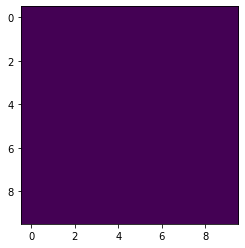

In [32]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# 新建一个游戏
game = GameState()
print(game.playery)

fig = plt.figure()
axe = fig.add_subplot(111)
dat = np.zeros((10, 10))
img = axe.imshow(dat)

# 进行100步循环，并将每一帧的画面打印出来
#for i in range(10):
#    clear_output(wait = True)
#    image_data, reward, terminal = game.frame_step([0,1])
#    image = np.transpose(image_data, (1, 0, 2))
#    img.set_data(image)
#    img.autoscale()
#    display(fig)
##    
#for i in range(10):
#    clear_output(wait = True)
#    image_data, reward, terminal = game.frame_step([1,0])
#    image = np.transpose(image_data, (1, 0, 2))
#    img.set_data(image)
#    img.autoscale()
#    display(fig)

NameError: name 'IMAGES' is not defined